### Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Loading in Cityscapes
see https://www.cityscapes-dataset.com/
> note: need "gtfine" and "leftimg8bit"
- there are 30 classes in the dataset

img shape: torch.Size([3, 1024, 2048])


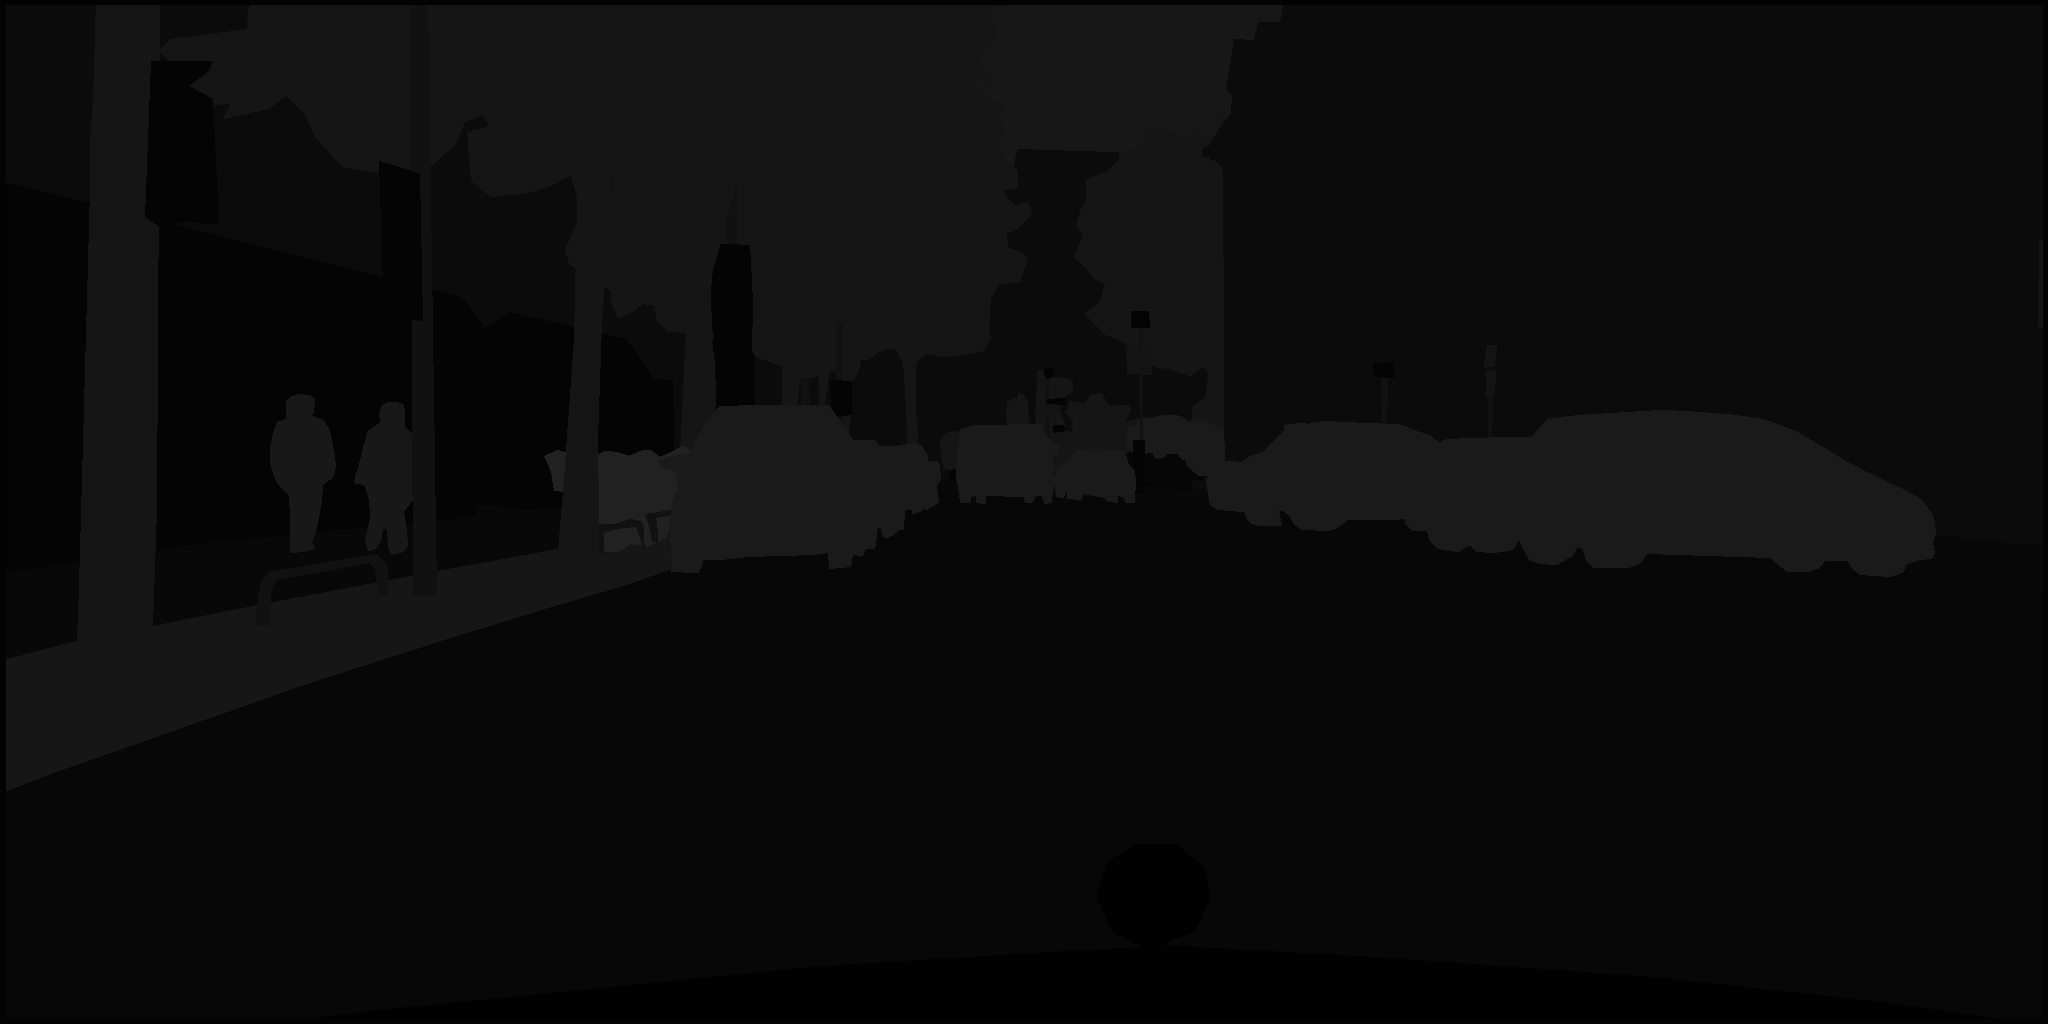

In [13]:
# Load the Cityscapes dataset
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # common ImageNet values
])

city_train = datasets.Cityscapes('./data/', split='train', mode='fine', transform=tfs, target_type='semantic')
city_test = datasets.Cityscapes('./data/', split='test', mode='fine', transform=tfs, target_type='semantic')
city_val = datasets.Cityscapes('./data/', split='val', mode='fine', transform=tfs, target_type='semantic')

dataloader = DataLoader(city_train, batch_size=4, shuffle=True, num_workers=4)

img, smnt = city_train[0]
print("img shape:", img.shape)
smnt

### Build Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
# Define the deconvolution network architecture
class DeconvNet(nn.Module):
    def __init__(self, num_classes):
        super(DeconvNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        # Decoder
        self.deconv2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2)
        )
        self.deconv1 = nn.Sequential(
            nn.Conv2d(128 + 64, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2)
        )
        self.final = nn.Conv2d(64 + 3, num_classes, 1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)

        deconv2 = self.deconv2(conv2)
        concat2 = torch.cat([deconv2, conv1], dim=1)
        deconv1 = self.deconv1(concat2)
        concat1 = torch.cat([deconv1, x], dim=1)
        output = self.final(concat1)

        return output

In [16]:
num_class = city_train.classes.__len__() # 30 classes

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
model = DeconvNet(num_classes=num_class).cuda()
optimizer = optim.Adam(model.parameters())

# Train the network
model.train()
for epoch in range(10):

    # track loss
    running_loss = 0.0

    for i, (img, smnt) in enumerate(dataloader):
        img, smnt = img.cuda(), smnt.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output = model(img)
        loss = criterion(output, smnt)

        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 0:
            print(f'epoch {epoch}, iter {i}, loss {loss.item()}')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx